In [1]:
import pandas as pd
import numpy as np
from scipy.stats import spearmanr,pearsonr
from glob import glob
import lightgbm as lgb
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import utils
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def resample_by_y_abs(df, n_samples_per_group=500):
    df = df.assign(y_abs=df['y_1'].abs())
    df_sorted = df.sort_values(by='y_abs', ascending=False)
    idx = df_sorted.index[n_samples_per_group:-n_samples_per_group]
    df_tail =  df_sorted.drop(idx,axis=0)
    df_mid = df_sorted.iloc[n_samples_per_group:-n_samples_per_group].sample(n=500, random_state=42)
    return pd.concat([df_tail,df_mid],axis=0)
sampled_data = utils.df_train
# grouped_train = sampled_data.groupby('datetime')
# df_train_resampled = grouped_train.apply(resample_by_y_abs,1000)
df_train_resampled = sampled_data
X_train = df_train_resampled.loc[:, 'X_1':'X_260']
y_train = df_train_resampled['y_2']
X_test = utils.df_test.loc[:, 'X_1':'X_260']
y_test = utils.df_test['y_1']


<AxesSubplot: xlabel='y_2', ylabel='Count'>

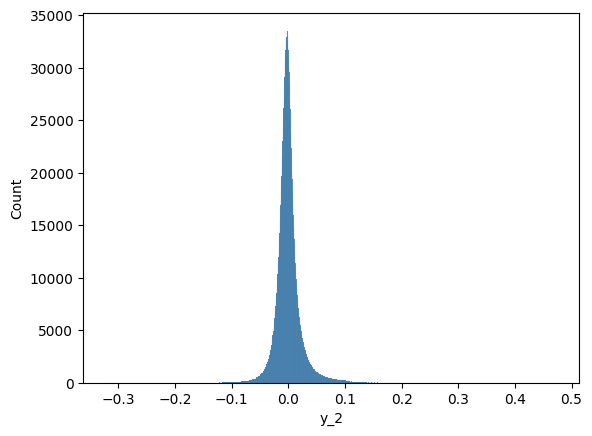

In [3]:
sns.histplot(y_train)

In [4]:
# Split the training data into training and validation sets
X_train_lgb, X_val_lgb, y_train_lgb, y_val_lgb = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42
)

# Create a LightGBM dataset
train_data = lgb.Dataset(X_train_lgb, label=y_train_lgb)
val_data = lgb.Dataset(X_val_lgb, label=y_val_lgb, reference=train_data)
params = {
    "objective": "regression",
    "boosting_type": "gbdt",
    "metric": "rmse",
    "n_jobs": -1,
    "verbosity": -1,
}
params_ = utils.read_yaml_to_dict('./configs/lgb_tuning_20230406113448.yaml')
params.update(params_)

gbm = lgb.train(params, train_data, valid_sets=[val_data], early_stopping_rounds=100)
y_pred_lgb = gbm.predict(X_test, num_iteration=gbm.best_iteration)


/home/ray/anaconda3/envs/ag/lib/python3.9/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[1]	valid_0's rmse: 0.0222814
Training until validation scores don't improve for 100 rounds
[2]	valid_0's rmse: 0.0222687
[3]	valid_0's rmse: 0.0222579
[4]	valid_0's rmse: 0.0222487
[5]	valid_0's rmse: 0.0222408
[6]	valid_0's rmse: 0.0222335
[7]	valid_0's rmse: 0.0222268
[8]	valid_0's rmse: 0.0222211
[9]	valid_0's rmse: 0.0222165
[10]	valid_0's rmse: 0.0222124
[11]	valid_0's rmse: 0.0222088
[12]	valid_0's rmse: 0.0222052
[13]	valid_0's rmse: 0.0222019
[14]	valid_0's rmse: 0.0221993
[15]	valid_0's rmse: 0.0221967
[16]	valid_0's rmse: 0.0221944
[17]	valid_0's rmse: 0.0221924
[18]	valid_0's rmse: 0.0221903
[19]	valid_0's rmse: 0.0221886
[20]	valid_0's rmse: 0.0221868
[21]	valid_0's rmse: 0.0221855
[22]	valid_0's rmse: 0.0221841
[23]	valid_0's rmse: 0.0221828
[24]	valid_0's rmse: 0.0221815
[25]	valid_0's rmse: 0.0221799
[26]	valid_0's rmse: 0.0221787
[27]	valid_0's rmse: 0.0221778
[28]	valid_0's rmse: 0.022177
[29]	valid_0's rmse: 0.0221762
[30]	valid_0's rmse: 0.0221756
[31]	valid_0's rms

In [5]:
# Evaluate model performance
mse = mean_squared_error(y_test, y_pred_lgb)
r2 = r2_score(y_test, y_pred_lgb)

print(f"Mean Squared Error: {mse:.5f}")
print(f"R^2: {r2:.5f}")

# Use the ModelEvaluator class to evaluate other metrics
evaluator_lgb = utils.ModelMetrics(y_test, y_pred_lgb,utils.df_test.date)
evaluator_lgb.evaluate()

Mean Squared Error: 0.00080
R^2: 0.00443
Information Coefficient: 0.07072
Average Returns of Top 10%: -0.00039
Accuracy of Top 10%: 0.13255


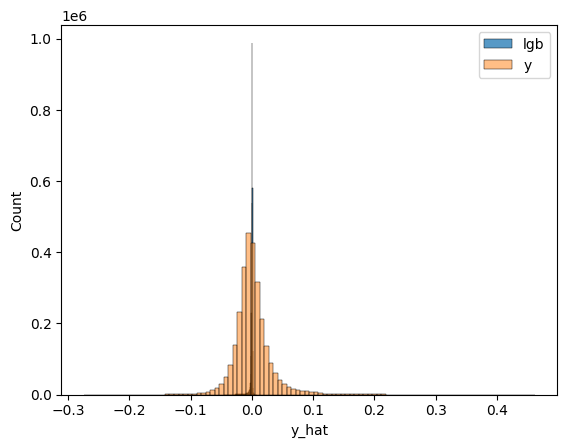

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
pred = pd.DataFrame({'y':y_test,'y_hat':y_pred_lgb,'bench':utils.df_test.benchmark_yhat})
sns.histplot(pred['y_hat'],bins=100,label='lgb')
# sns.histplot(pred['bench'],bins=100,label='bench',alpha=0.5)
sns.histplot(pred.y,bins=100,label='y',alpha=0.5)
plt.legend()


<AxesSubplot: xlabel='y', ylabel='Count'>

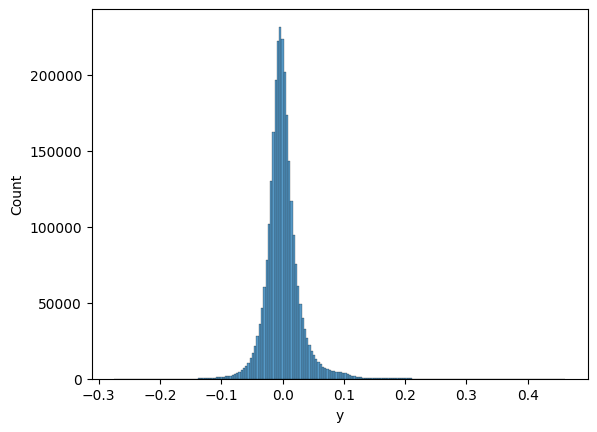

In [7]:
sns.histplot(pred['y'],bins=200)

<AxesSubplot: xlabel='y', ylabel='y_hat'>

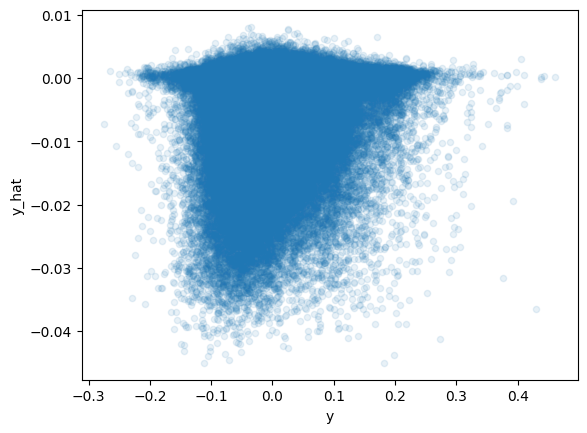

In [8]:
pred.plot(kind='scatter',x='y',y='y_hat',alpha=0.1)

<AxesSubplot: ylabel='Count'>

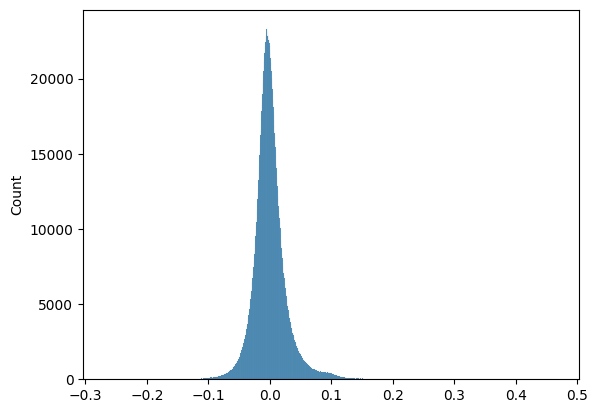

In [14]:
sns.histplot(pred.y-pred.y_hat)

In [15]:
(pred.y-pred.y_hat).describe()

count    2.813980e+06
mean     3.574311e-04
std      2.832846e-02
min     -2.670841e-01
25%     -1.421730e-02
50%     -2.158284e-03
75%      1.152769e-02
max      4.665505e-01
dtype: float64

In [9]:
t = utils.ModelMetrics(utils.df_test.benchmark_yhat,utils.df_test.y_1,utils.test_date)

In [10]:
t.evaluate()

Information Coefficient: 0.07124
Average Returns of Top 10%: 0.00194
Accuracy of Top 10%: 0.12351
